# Weather prediction dataset - regression task: tomorrow sunshine hours 
Code examples rougly sorted from simple dense neural networks (only dense layers), to more complex networks that include `Dropout` and/or `BatchNormalization` to prevent overfitting.

Second part contains examples on how to apply `Monte-Carlo Dropout` to evaluate the model uncertainty.

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
path_root = os.path.dirname(os.getcwd())
path_data = os.path.join(path_root, "dataset")
filename_data = os.path.join(path_data, "weather_prediction_dataset.csv")

In [3]:
data = pd.read_csv(filename_data)
data.head()

,DATE,MONTH,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,...,STOCKHOLM_temp_min,STOCKHOLM_temp_max,TOURS_wind_speed,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
0,20000101,1,8,0.89,1.0286,0.20,0.03,0.0,2.9,1.6,...,-9.3,0.7,1.6,0.97,1.0275,0.25,0.04,8.5,7.2,9.8
1,20000102,1,8,0.87,1.0318,0.25,0.00,0.0,3.6,2.7,...,0.5,2.0,2.0,0.99,1.0293,0.17,0.16,7.9,6.6,9.2
2,20000103,1,5,0.81,1.0314,0.50,0.00,3.7,2.2,0.1,...,-1.0,2.8,3.4,0.91,1.0267,0.27,0.00,8.1,6.6,9.6
3,20000104,1,7,0.79,1.0262,0.63,0.35,6.9,3.9,0.5,...,2.5,4.6,4.9,0.95,1.0222,0.11,0.44,8.6,6.4,10.8
4,20000105,1,5,0.90,1.0246,0.51,0.07,3.7,6.0,3.8,...,-1.8,2.9,3.6,0.95,1.0209,0.39,0.04,8.0,6.4,9.5


In [4]:
data.iloc[:5,:5]

,DATE,MONTH,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure
0,20000101,1,8,0.89,1.0286
1,20000102,1,8,0.87,1.0318
2,20000103,1,5,0.81,1.0314
3,20000104,1,7,0.79,1.0262
4,20000105,1,5,0.90,1.0246


In [5]:
list({x.split("_")[0] for x in data.columns if x not in ["MONTH", "DATE"]})

['ROMA',
 'LJUBLJANA',
 'DRESDEN',
 'DUSSELDORF',
 'KASSEL',
 'PERPIGNAN',
 'DE',
 'HEATHROW',
 'SONNBLICK',
 'MAASTRICHT',
 'BUDAPEST',
 'STOCKHOLM',
 'MALMO',
 'MUENCHEN',
 'MONTELIMAR',
 'TOURS',
 'OSLO',
 'BASEL']

# Split data into data (X) and labels (y)
We here want to predict the sunshine hours for a particular place (say BASEL which is about in the center of all 18 locations). 

In [6]:
# data
X_data = data.loc[:365*3].drop(columns=['DATE', 'MONTH'])

# labels (sunshine hours the next day)
y_data = data.loc[1:(365*3 + 1)]["BASEL_sunshine"]

In [7]:
X_data.head()

,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,BASEL_temp_max,BUDAPEST_cloud_cover,...,STOCKHOLM_temp_min,STOCKHOLM_temp_max,TOURS_wind_speed,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
0,8,0.89,1.0286,0.20,0.03,0.0,2.9,1.6,3.9,3,...,-9.3,0.7,1.6,0.97,1.0275,0.25,0.04,8.5,7.2,9.8
1,8,0.87,1.0318,0.25,0.00,0.0,3.6,2.7,4.8,8,...,0.5,2.0,2.0,0.99,1.0293,0.17,0.16,7.9,6.6,9.2
2,5,0.81,1.0314,0.50,0.00,3.7,2.2,0.1,4.8,6,...,-1.0,2.8,3.4,0.91,1.0267,0.27,0.00,8.1,6.6,9.6
3,7,0.79,1.0262,0.63,0.35,6.9,3.9,0.5,7.5,8,...,2.5,4.6,4.9,0.95,1.0222,0.11,0.44,8.6,6.4,10.8
4,5,0.90,1.0246,0.51,0.07,3.7,6.0,3.8,8.6,5,...,-1.8,2.9,3.6,0.95,1.0209,0.39,0.04,8.0,6.4,9.5


<AxesSubplot:>

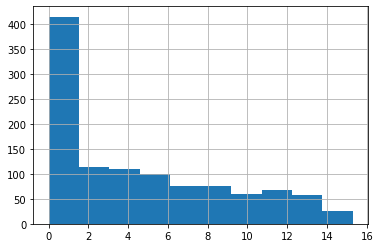

In [8]:
y_data.hist()

# Split data into training, validation, and test set

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=0) 
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

print(f"Data split into training ({X_train.shape[0]})," \
      f" validation ({X_val.shape[0]}) and test set ({X_test.shape[0]}).") 

Data split into training (767), validation (164) and test set (165).


In [10]:
# this also shuffled the data!
y_train[:10]

459     1.0
182     9.6
428     0.0
816    10.2
10      0.0
454     2.5
821    11.2
579     8.3
753     0.0
849     2.9
Name: BASEL_sunshine, dtype: float64

In [11]:
y_train.max(), y_train.min()

(15.3, 0.0)

# 1) Start simple: Build small neural network

In [12]:
X_train.shape, y_train.shape

((767, 163), (767,))

In [13]:
from tensorflow import keras
from tensorflow.keras.models import Model

def create_nn(n_features, n_predictions):
    # Input layer
    input = keras.layers.Input(shape=(n_features,), name='input')

    # Dense layers
    layers_dense = keras.layers.Dense(10, 'relu')(input)
    layers_dense = keras.layers.Dense(5, 'relu')(layers_dense)

    # Output layer
    output = keras.layers.Dense(n_predictions)(layers_dense)

    # Defining the model and compiling it
    return Model(inputs=input, outputs=output, name="weather_prediction_model")

n_features = X_data.shape[1]
n_predictions = 1

model = create_nn(n_features, n_predictions)
model.summary()

Model: "weather_prediction_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 163)]             0         
_________________________________________________________________
dense (Dense)                (None, 10)                1640      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 1,701
Trainable params: 1,701
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(loss='mse', optimizer=keras.optimizers.Adam(),
              metrics=['mae', tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=200,
                    verbose=2)

Epoch 1/200
24/24 - 1s - loss: 18.9130 - mae: 3.6049 - root_mean_squared_error: 4.3489
Epoch 2/200
24/24 - 0s - loss: 15.6490 - mae: 3.4313 - root_mean_squared_error: 3.9559
Epoch 3/200
24/24 - 0s - loss: 14.9220 - mae: 3.2950 - root_mean_squared_error: 3.8629
Epoch 4/200
24/24 - 0s - loss: 14.4519 - mae: 3.2476 - root_mean_squared_error: 3.8016
Epoch 5/200
24/24 - 0s - loss: 14.0242 - mae: 3.1814 - root_mean_squared_error: 3.7449
Epoch 6/200
24/24 - 0s - loss: 13.7721 - mae: 3.1245 - root_mean_squared_error: 3.7111
Epoch 7/200
24/24 - 0s - loss: 13.3881 - mae: 3.0636 - root_mean_squared_error: 3.6590
Epoch 8/200
24/24 - 0s - loss: 13.1575 - mae: 3.0328 - root_mean_squared_error: 3.6273
Epoch 9/200
24/24 - 0s - loss: 12.9977 - mae: 2.9881 - root_mean_squared_error: 3.6052
Epoch 10/200
24/24 - 0s - loss: 12.8322 - mae: 2.9637 - root_mean_squared_error: 3.5822
Epoch 11/200
24/24 - 0s - loss: 12.4792 - mae: 2.9246 - root_mean_squared_error: 3.5326
Epoch 12/200
24/24 - 0s - loss: 12.2635 -

Epoch 95/200
24/24 - 0s - loss: 7.2659 - mae: 2.0388 - root_mean_squared_error: 2.6955
Epoch 96/200
24/24 - 0s - loss: 7.1469 - mae: 2.0495 - root_mean_squared_error: 2.6734
Epoch 97/200
24/24 - 0s - loss: 7.3620 - mae: 2.0672 - root_mean_squared_error: 2.7133
Epoch 98/200
24/24 - 0s - loss: 7.2192 - mae: 2.0502 - root_mean_squared_error: 2.6869
Epoch 99/200
24/24 - 0s - loss: 7.1189 - mae: 2.0286 - root_mean_squared_error: 2.6681
Epoch 100/200
24/24 - 0s - loss: 7.1433 - mae: 2.0288 - root_mean_squared_error: 2.6727
Epoch 101/200
24/24 - 0s - loss: 6.9746 - mae: 2.0179 - root_mean_squared_error: 2.6409
Epoch 102/200
24/24 - 0s - loss: 6.9433 - mae: 2.0121 - root_mean_squared_error: 2.6350
Epoch 103/200
24/24 - 0s - loss: 7.1531 - mae: 2.0458 - root_mean_squared_error: 2.6745
Epoch 104/200
24/24 - 0s - loss: 7.2306 - mae: 2.0625 - root_mean_squared_error: 2.6890
Epoch 105/200
24/24 - 0s - loss: 6.9200 - mae: 2.0037 - root_mean_squared_error: 2.6306
Epoch 106/200
24/24 - 0s - loss: 6.94

Epoch 189/200
24/24 - 0s - loss: 5.1583 - mae: 1.6992 - root_mean_squared_error: 2.2712
Epoch 190/200
24/24 - 0s - loss: 5.3825 - mae: 1.7195 - root_mean_squared_error: 2.3200
Epoch 191/200
24/24 - 0s - loss: 5.1621 - mae: 1.6863 - root_mean_squared_error: 2.2720
Epoch 192/200
24/24 - 0s - loss: 5.0582 - mae: 1.6812 - root_mean_squared_error: 2.2490
Epoch 193/200
24/24 - 0s - loss: 5.1089 - mae: 1.6823 - root_mean_squared_error: 2.2603
Epoch 194/200
24/24 - 0s - loss: 5.0561 - mae: 1.6489 - root_mean_squared_error: 2.2486
Epoch 195/200
24/24 - 0s - loss: 4.9610 - mae: 1.6569 - root_mean_squared_error: 2.2273
Epoch 196/200
24/24 - 0s - loss: 4.9291 - mae: 1.6402 - root_mean_squared_error: 2.2202
Epoch 197/200
24/24 - 0s - loss: 5.1489 - mae: 1.6929 - root_mean_squared_error: 2.2691
Epoch 198/200
24/24 - 0s - loss: 5.1684 - mae: 1.7129 - root_mean_squared_error: 2.2734
Epoch 199/200
24/24 - 0s - loss: 5.2385 - mae: 1.7136 - root_mean_squared_error: 2.2888
Epoch 200/200
24/24 - 0s - loss:

Text(0, 0.5, 'RMSE')

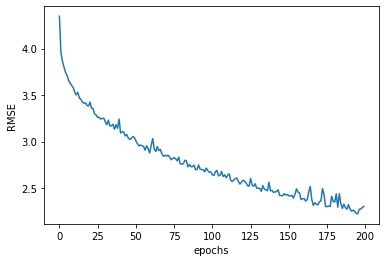

In [15]:
import seaborn as sns

history_df = pd.DataFrame.from_dict(history.history)
sns.lineplot(data=history_df['root_mean_squared_error'])
plt.xlabel("epochs")
plt.ylabel("RMSE")
#plt.savefig("03_training_history_1_rmse.png", dpi=200)

Text(0.5, 0, 'epochs')

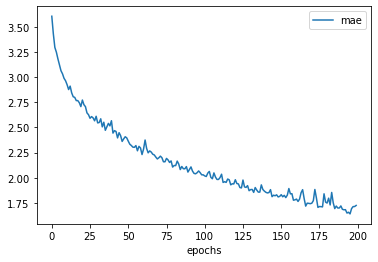

In [16]:
history_df = pd.DataFrame.from_dict(history.history)
sns.lineplot(data=history_df[['mae']])
plt.xlabel("epochs")
#plt.savefig("03_training_history_1_mae.png", dpi=200)

## Evaluate the model on the train and the test set

In [17]:
# Predict the sunshine hours
y_train_predicted = model.predict(X_train)
y_test_predicted = model.predict(X_test)

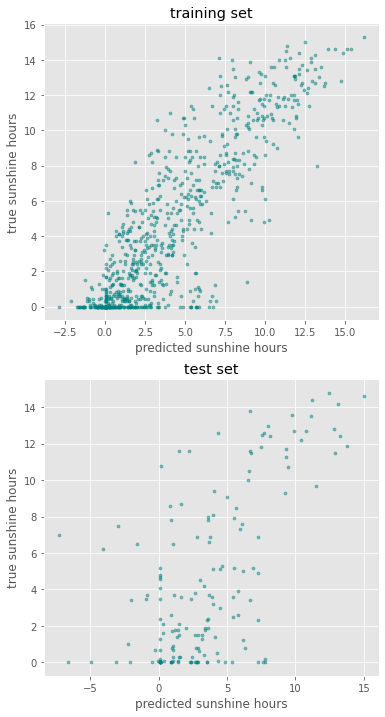

In [18]:
plt.style.use('ggplot')
fig, axes = plt.subplots(2, 1, figsize=(6, 12))

axes[0].scatter(y_train_predicted, y_train, s=10, alpha=0.5, color="teal")
axes[0].set_title("training set")
axes[0].set_xlabel("predicted sunshine hours")
axes[0].set_ylabel("true sunshine hours")

axes[1].scatter(y_test_predicted, y_test, s=10, alpha=0.5, color="teal")
axes[1].set_title("test set")
axes[1].set_xlabel("predicted sunshine hours")
axes[1].set_ylabel("true sunshine hours")

#plt.savefig("sunshine_tomorrow_training_test.png", dpi=300)
plt.savefig("sunshine_tomorrow_training_test.pdf")

## Use the validation set to monitor the training process

In [19]:
model = create_nn(n_features=X_train.shape[1], n_predictions=1)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "weather_prediction_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 163)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1640      
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 6         
Total params: 1,701
Trainable params: 1,701
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model.fit(X_train, y_train,
                    batch_size = 32,
                    epochs = 200,
                    validation_data=(X_val, y_val), verbose = 2)

Epoch 1/200
24/24 - 3s - loss: 19.0293 - root_mean_squared_error: 4.3623 - val_loss: 16.6933 - val_root_mean_squared_error: 4.0857
Epoch 2/200
24/24 - 0s - loss: 16.0011 - root_mean_squared_error: 4.0001 - val_loss: 13.0758 - val_root_mean_squared_error: 3.6160
Epoch 3/200
24/24 - 0s - loss: 14.0665 - root_mean_squared_error: 3.7505 - val_loss: 13.2841 - val_root_mean_squared_error: 3.6447
Epoch 4/200
24/24 - 0s - loss: 14.0691 - root_mean_squared_error: 3.7509 - val_loss: 12.0818 - val_root_mean_squared_error: 3.4759
Epoch 5/200
24/24 - 0s - loss: 13.2387 - root_mean_squared_error: 3.6385 - val_loss: 11.7774 - val_root_mean_squared_error: 3.4318
Epoch 6/200
24/24 - 0s - loss: 13.0625 - root_mean_squared_error: 3.6142 - val_loss: 11.9804 - val_root_mean_squared_error: 3.4613
Epoch 7/200
24/24 - 0s - loss: 13.0157 - root_mean_squared_error: 3.6077 - val_loss: 11.3833 - val_root_mean_squared_error: 3.3739
Epoch 8/200
24/24 - 0s - loss: 12.6488 - root_mean_squared_error: 3.5565 - val_loss

Epoch 64/200
24/24 - 0s - loss: 8.6137 - root_mean_squared_error: 2.9349 - val_loss: 9.3658 - val_root_mean_squared_error: 3.0604
Epoch 65/200
24/24 - 0s - loss: 10.0051 - root_mean_squared_error: 3.1631 - val_loss: 10.8741 - val_root_mean_squared_error: 3.2976
Epoch 66/200
24/24 - 0s - loss: 8.9946 - root_mean_squared_error: 2.9991 - val_loss: 9.5277 - val_root_mean_squared_error: 3.0867
Epoch 67/200
24/24 - 0s - loss: 8.8650 - root_mean_squared_error: 2.9774 - val_loss: 9.8850 - val_root_mean_squared_error: 3.1440
Epoch 68/200
24/24 - 0s - loss: 9.1296 - root_mean_squared_error: 3.0215 - val_loss: 10.4613 - val_root_mean_squared_error: 3.2344
Epoch 69/200
24/24 - 0s - loss: 8.8633 - root_mean_squared_error: 2.9771 - val_loss: 9.9538 - val_root_mean_squared_error: 3.1550
Epoch 70/200
24/24 - 0s - loss: 8.5598 - root_mean_squared_error: 2.9257 - val_loss: 9.8465 - val_root_mean_squared_error: 3.1379
Epoch 71/200
24/24 - 0s - loss: 8.5905 - root_mean_squared_error: 2.9310 - val_loss: 9.

Epoch 127/200
24/24 - 0s - loss: 7.3250 - root_mean_squared_error: 2.7065 - val_loss: 9.8025 - val_root_mean_squared_error: 3.1309
Epoch 128/200
24/24 - 0s - loss: 7.5561 - root_mean_squared_error: 2.7488 - val_loss: 10.6134 - val_root_mean_squared_error: 3.2578
Epoch 129/200
24/24 - 0s - loss: 6.9735 - root_mean_squared_error: 2.6407 - val_loss: 10.0789 - val_root_mean_squared_error: 3.1747
Epoch 130/200
24/24 - 0s - loss: 7.2795 - root_mean_squared_error: 2.6981 - val_loss: 9.5250 - val_root_mean_squared_error: 3.0863
Epoch 131/200
24/24 - 0s - loss: 7.4934 - root_mean_squared_error: 2.7374 - val_loss: 10.4821 - val_root_mean_squared_error: 3.2376
Epoch 132/200
24/24 - 0s - loss: 7.7590 - root_mean_squared_error: 2.7855 - val_loss: 9.4700 - val_root_mean_squared_error: 3.0773
Epoch 133/200
24/24 - 0s - loss: 7.2243 - root_mean_squared_error: 2.6878 - val_loss: 10.1259 - val_root_mean_squared_error: 3.1821
Epoch 134/200
24/24 - 0s - loss: 6.8270 - root_mean_squared_error: 2.6129 - val

Epoch 190/200
24/24 - 0s - loss: 5.7266 - root_mean_squared_error: 2.3930 - val_loss: 10.7751 - val_root_mean_squared_error: 3.2825
Epoch 191/200
24/24 - 0s - loss: 6.0100 - root_mean_squared_error: 2.4515 - val_loss: 11.1519 - val_root_mean_squared_error: 3.3395
Epoch 192/200
24/24 - 0s - loss: 5.6344 - root_mean_squared_error: 2.3737 - val_loss: 11.4873 - val_root_mean_squared_error: 3.3893
Epoch 193/200
24/24 - 0s - loss: 5.5394 - root_mean_squared_error: 2.3536 - val_loss: 10.8137 - val_root_mean_squared_error: 3.2884
Epoch 194/200
24/24 - 0s - loss: 5.8169 - root_mean_squared_error: 2.4118 - val_loss: 11.4312 - val_root_mean_squared_error: 3.3810
Epoch 195/200
24/24 - 0s - loss: 5.7625 - root_mean_squared_error: 2.4005 - val_loss: 11.5046 - val_root_mean_squared_error: 3.3918
Epoch 196/200
24/24 - 0s - loss: 5.4637 - root_mean_squared_error: 2.3375 - val_loss: 11.0611 - val_root_mean_squared_error: 3.3258
Epoch 197/200
24/24 - 0s - loss: 5.6329 - root_mean_squared_error: 2.3734 - 

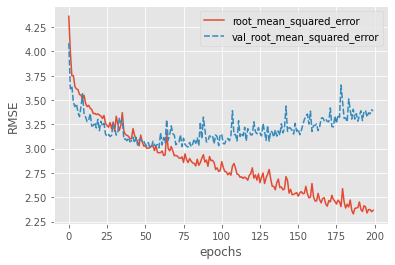

In [21]:
import seaborn as sns

history_df = pd.DataFrame.from_dict(history.history)
sns.lineplot(data=history_df[['root_mean_squared_error', 'val_root_mean_squared_error']])
plt.xlabel("epochs")
plt.ylabel("RMSE")

#plt.savefig("03_training_history_2_rmse.png", dpi=200)
plt.savefig("training_history_2_rmse.pdf")

## Multiple observations --> somethings wrong with training!
- Severe overfitting! (validation loss >> training loss)
- No smooth learning process: Large jumps in losses over epochs!

# Improve network -> Remedy 1: make network smaler!

In [22]:
def create_nn(n_features, n_predictions):
    # Input layer
    input = keras.layers.Input(shape=(n_features,), name='input')

    # Dense layers
    layers_dense = keras.layers.Dense(10, 'relu')(input)
    layers_dense = keras.layers.Dense(5, 'relu')(layers_dense)

    # Output layer
    output = keras.layers.Dense(n_predictions)(layers_dense)

    # Defining the model and compiling it
    return Model(inputs=input, outputs=output, name="small_prediction_model")

n_features = X_data.shape[1]
n_predictions = 1

model = create_nn(n_features, n_predictions)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(), metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "small_prediction_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 163)]             0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1640      
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 6         
Total params: 1,701
Trainable params: 1,701
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = model.fit(X_train, y_train,
                    batch_size = 32,
                    epochs = 200,
                    validation_data=(X_val, y_val), verbose = 2)

Epoch 1/200
24/24 - 2s - loss: 17.2419 - root_mean_squared_error: 4.1523 - val_loss: 15.7284 - val_root_mean_squared_error: 3.9659
Epoch 2/200
24/24 - 0s - loss: 15.3734 - root_mean_squared_error: 3.9209 - val_loss: 15.2089 - val_root_mean_squared_error: 3.8999
Epoch 3/200
24/24 - 0s - loss: 14.7848 - root_mean_squared_error: 3.8451 - val_loss: 14.6867 - val_root_mean_squared_error: 3.8323
Epoch 4/200
24/24 - 0s - loss: 14.3964 - root_mean_squared_error: 3.7943 - val_loss: 13.9960 - val_root_mean_squared_error: 3.7411
Epoch 5/200
24/24 - 0s - loss: 13.7180 - root_mean_squared_error: 3.7038 - val_loss: 13.1332 - val_root_mean_squared_error: 3.6240
Epoch 6/200
24/24 - 0s - loss: 13.2587 - root_mean_squared_error: 3.6413 - val_loss: 12.4594 - val_root_mean_squared_error: 3.5298
Epoch 7/200
24/24 - 0s - loss: 12.8503 - root_mean_squared_error: 3.5847 - val_loss: 12.5287 - val_root_mean_squared_error: 3.5396
Epoch 8/200
24/24 - 0s - loss: 12.6210 - root_mean_squared_error: 3.5526 - val_loss

Epoch 64/200
24/24 - 0s - loss: 8.9990 - root_mean_squared_error: 2.9998 - val_loss: 10.1381 - val_root_mean_squared_error: 3.1840
Epoch 65/200
24/24 - 0s - loss: 8.8242 - root_mean_squared_error: 2.9706 - val_loss: 9.7108 - val_root_mean_squared_error: 3.1162
Epoch 66/200
24/24 - 0s - loss: 8.5561 - root_mean_squared_error: 2.9251 - val_loss: 9.7770 - val_root_mean_squared_error: 3.1268
Epoch 67/200
24/24 - 0s - loss: 8.6384 - root_mean_squared_error: 2.9391 - val_loss: 9.6527 - val_root_mean_squared_error: 3.1069
Epoch 68/200
24/24 - 0s - loss: 8.4169 - root_mean_squared_error: 2.9012 - val_loss: 9.5920 - val_root_mean_squared_error: 3.0971
Epoch 69/200
24/24 - 0s - loss: 8.6648 - root_mean_squared_error: 2.9436 - val_loss: 10.5710 - val_root_mean_squared_error: 3.2513
Epoch 70/200
24/24 - 0s - loss: 8.5433 - root_mean_squared_error: 2.9229 - val_loss: 9.6933 - val_root_mean_squared_error: 3.1134
Epoch 71/200
24/24 - 0s - loss: 8.5021 - root_mean_squared_error: 2.9158 - val_loss: 9.8

Epoch 127/200
24/24 - 0s - loss: 7.1933 - root_mean_squared_error: 2.6820 - val_loss: 9.5450 - val_root_mean_squared_error: 3.0895
Epoch 128/200
24/24 - 0s - loss: 6.7750 - root_mean_squared_error: 2.6029 - val_loss: 9.7334 - val_root_mean_squared_error: 3.1198
Epoch 129/200
24/24 - 0s - loss: 6.8200 - root_mean_squared_error: 2.6115 - val_loss: 9.7447 - val_root_mean_squared_error: 3.1216
Epoch 130/200
24/24 - 0s - loss: 7.0414 - root_mean_squared_error: 2.6536 - val_loss: 9.5710 - val_root_mean_squared_error: 3.0937
Epoch 131/200
24/24 - 0s - loss: 6.9223 - root_mean_squared_error: 2.6310 - val_loss: 9.8613 - val_root_mean_squared_error: 3.1403
Epoch 132/200
24/24 - 0s - loss: 6.8658 - root_mean_squared_error: 2.6203 - val_loss: 9.8723 - val_root_mean_squared_error: 3.1420
Epoch 133/200
24/24 - 0s - loss: 6.8508 - root_mean_squared_error: 2.6174 - val_loss: 9.6416 - val_root_mean_squared_error: 3.1051
Epoch 134/200
24/24 - 0s - loss: 6.8785 - root_mean_squared_error: 2.6227 - val_los

Epoch 190/200
24/24 - 0s - loss: 6.1904 - root_mean_squared_error: 2.4881 - val_loss: 10.7170 - val_root_mean_squared_error: 3.2737
Epoch 191/200
24/24 - 0s - loss: 6.3073 - root_mean_squared_error: 2.5114 - val_loss: 10.2505 - val_root_mean_squared_error: 3.2016
Epoch 192/200
24/24 - 0s - loss: 6.1646 - root_mean_squared_error: 2.4829 - val_loss: 10.3251 - val_root_mean_squared_error: 3.2133
Epoch 193/200
24/24 - 0s - loss: 6.3288 - root_mean_squared_error: 2.5157 - val_loss: 10.6937 - val_root_mean_squared_error: 3.2701
Epoch 194/200
24/24 - 0s - loss: 6.0892 - root_mean_squared_error: 2.4676 - val_loss: 10.0682 - val_root_mean_squared_error: 3.1730
Epoch 195/200
24/24 - 0s - loss: 5.9370 - root_mean_squared_error: 2.4366 - val_loss: 10.0101 - val_root_mean_squared_error: 3.1639
Epoch 196/200
24/24 - 0s - loss: 5.9161 - root_mean_squared_error: 2.4323 - val_loss: 10.0775 - val_root_mean_squared_error: 3.1745
Epoch 197/200
24/24 - 0s - loss: 5.9314 - root_mean_squared_error: 2.4355 - 

Text(0, 0.5, 'RMSE')

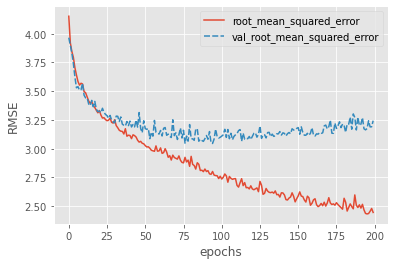

In [24]:
history_df = pd.DataFrame.from_dict(history.history)
sns.lineplot(data=history_df[['root_mean_squared_error', 'val_root_mean_squared_error']])
plt.xlabel("epochs")
plt.ylabel("RMSE")
#plt.savefig("03_training_history_3_rmse_smaller_model.png", dpi=200)

## --> here: works a bit, when size is reduced A LOT! But still clearly overfitting...

# Improve network ->  Remedy 2: early stopping

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

earlystopper = EarlyStopping(
    monitor='val_loss', mode="min",
    patience=10,
    verbose=1
    )

model = create_nn(n_features=X_train.shape[1], n_predictions=1)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

history = model.fit(X_train, y_train,
                    batch_size = 32,
                    epochs = 200,
                    validation_data=(X_val, y_val),
                    callbacks=[earlystopper],
                    verbose = 2)

Epoch 1/200
24/24 - 1s - loss: 23.0480 - root_mean_squared_error: 4.8008 - val_loss: 17.2559 - val_root_mean_squared_error: 4.1540
Epoch 2/200
24/24 - 0s - loss: 16.2505 - root_mean_squared_error: 4.0312 - val_loss: 15.6400 - val_root_mean_squared_error: 3.9547
Epoch 3/200
24/24 - 0s - loss: 14.8188 - root_mean_squared_error: 3.8495 - val_loss: 13.9552 - val_root_mean_squared_error: 3.7357
Epoch 4/200
24/24 - 0s - loss: 14.3511 - root_mean_squared_error: 3.7883 - val_loss: 13.4987 - val_root_mean_squared_error: 3.6741
Epoch 5/200
24/24 - 0s - loss: 13.4474 - root_mean_squared_error: 3.6671 - val_loss: 13.0208 - val_root_mean_squared_error: 3.6084
Epoch 6/200
24/24 - 0s - loss: 13.1041 - root_mean_squared_error: 3.6200 - val_loss: 12.7400 - val_root_mean_squared_error: 3.5693
Epoch 7/200
24/24 - 0s - loss: 12.7880 - root_mean_squared_error: 3.5760 - val_loss: 13.0274 - val_root_mean_squared_error: 3.6093
Epoch 8/200
24/24 - 0s - loss: 12.5919 - root_mean_squared_error: 3.5485 - val_loss

Epoch 64/200
24/24 - 0s - loss: 8.8573 - root_mean_squared_error: 2.9761 - val_loss: 10.0755 - val_root_mean_squared_error: 3.1742
Epoch 65/200
24/24 - 0s - loss: 8.9184 - root_mean_squared_error: 2.9864 - val_loss: 9.9015 - val_root_mean_squared_error: 3.1467
Epoch 66/200
24/24 - 0s - loss: 8.8502 - root_mean_squared_error: 2.9749 - val_loss: 10.1301 - val_root_mean_squared_error: 3.1828
Epoch 67/200
24/24 - 0s - loss: 8.8773 - root_mean_squared_error: 2.9795 - val_loss: 9.9264 - val_root_mean_squared_error: 3.1506
Epoch 68/200
24/24 - 0s - loss: 8.5220 - root_mean_squared_error: 2.9193 - val_loss: 10.2767 - val_root_mean_squared_error: 3.2057
Epoch 69/200
24/24 - 0s - loss: 8.5897 - root_mean_squared_error: 2.9308 - val_loss: 10.2706 - val_root_mean_squared_error: 3.2048
Epoch 70/200
24/24 - 0s - loss: 8.6232 - root_mean_squared_error: 2.9365 - val_loss: 10.1114 - val_root_mean_squared_error: 3.1798
Epoch 71/200
24/24 - 0s - loss: 9.1199 - root_mean_squared_error: 3.0199 - val_loss: 

Text(0, 0.5, 'RMSE')

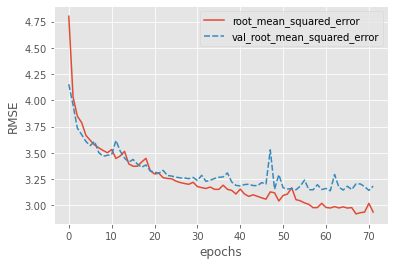

In [26]:
history_df = pd.DataFrame.from_dict(history.history)
sns.lineplot(data=history_df[['root_mean_squared_error', 'val_root_mean_squared_error']])
plt.xlabel("epochs")
plt.ylabel("RMSE")
#plt.savefig("03_training_history_3_rmse_early_stopping.png", dpi=200)

In [27]:
# Predict the sunshine hours
y_train_predicted = model.predict(X_train)
y_test_predicted = model.predict(X_test)

Text(0, 0.5, 'true sunshine hours')

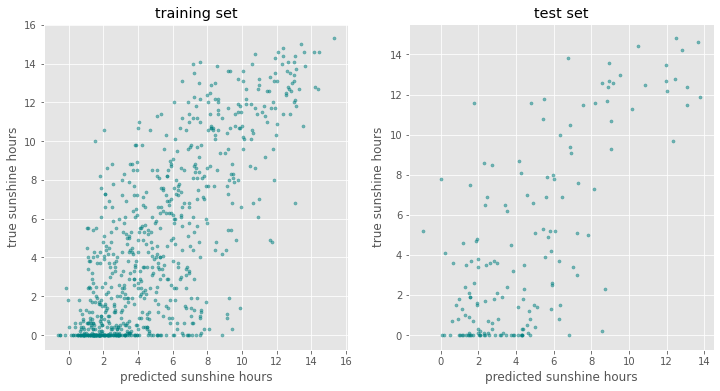

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.style.use('ggplot')
axes[0].scatter(y_train_predicted, y_train, s=10, alpha=0.5, color="teal")
axes[0].set_title("training set")
axes[0].set_xlabel("predicted sunshine hours")
axes[0].set_ylabel("true sunshine hours")

axes[1].scatter(y_test_predicted, y_test, s=10, alpha=0.5, color="teal")
axes[1].set_title("test set")
axes[1].set_xlabel("predicted sunshine hours")
axes[1].set_ylabel("true sunshine hours")

#plt.savefig("03_regression_compare_training_and_test_performance.png", dpi=200)

# Improve network ->  Remedy 3: add dropout

In [30]:
def create_nn(n_features, n_predictions):
    # Input layer
    layers_input = keras.layers.Input(shape=(n_features,), name='input')

    # Dense layers
    layers_dense = keras.layers.Dense(100, 'relu')(layers_input)
    layers_dense = keras.layers.Dropout(rate=0.2)(layers_dense)
    layers_dense = keras.layers.Dense(50, 'relu')(layers_dense)
    layers_dense = keras.layers.Dropout(rate=0.2)(layers_dense)

    # Output layer
    layers_output = keras.layers.Dense(n_predictions)(layers_dense)

    # Defining the model and compiling it
    return Model(inputs=layers_input, outputs=layers_output, name="dropout_prediction_model")

model = create_nn(X_data.shape[1], 1)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "dropout_prediction_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 163)]             0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               16400     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 51        
Total params: 21,501
Trainable params: 21,501
Non-trainable params: 0
______________________________________

In [31]:
earlystopper = EarlyStopping(
    monitor='val_loss', mode="min",
    patience=20,
    verbose=1
    )

history = model.fit(X_train, y_train,
                    batch_size = 32,
                    epochs = 200,
                    validation_data=(X_val, y_val),
                    callbacks=[earlystopper],
                    verbose = 2)

Epoch 1/200
24/24 - 1s - loss: 39.6529 - root_mean_squared_error: 6.2971 - val_loss: 14.9414 - val_root_mean_squared_error: 3.8654
Epoch 2/200
24/24 - 0s - loss: 17.0141 - root_mean_squared_error: 4.1248 - val_loss: 13.4634 - val_root_mean_squared_error: 3.6692
Epoch 3/200
24/24 - 0s - loss: 16.7838 - root_mean_squared_error: 4.0968 - val_loss: 12.5524 - val_root_mean_squared_error: 3.5429
Epoch 4/200
24/24 - 0s - loss: 16.4705 - root_mean_squared_error: 4.0584 - val_loss: 13.0472 - val_root_mean_squared_error: 3.6121
Epoch 5/200
24/24 - 0s - loss: 15.2156 - root_mean_squared_error: 3.9007 - val_loss: 13.1799 - val_root_mean_squared_error: 3.6304
Epoch 6/200
24/24 - 0s - loss: 14.4526 - root_mean_squared_error: 3.8017 - val_loss: 12.0859 - val_root_mean_squared_error: 3.4765
Epoch 7/200
24/24 - 0s - loss: 14.3349 - root_mean_squared_error: 3.7862 - val_loss: 11.1402 - val_root_mean_squared_error: 3.3377
Epoch 8/200
24/24 - 0s - loss: 13.1718 - root_mean_squared_error: 3.6293 - val_loss

Epoch 64/200
24/24 - 0s - loss: 8.7266 - root_mean_squared_error: 2.9541 - val_loss: 9.9885 - val_root_mean_squared_error: 3.1605
Epoch 65/200
24/24 - 0s - loss: 8.3899 - root_mean_squared_error: 2.8965 - val_loss: 10.1247 - val_root_mean_squared_error: 3.1819
Epoch 66/200
24/24 - 0s - loss: 8.9834 - root_mean_squared_error: 2.9972 - val_loss: 10.5394 - val_root_mean_squared_error: 3.2465
Epoch 67/200
24/24 - 0s - loss: 9.1695 - root_mean_squared_error: 3.0281 - val_loss: 11.1020 - val_root_mean_squared_error: 3.3320
Epoch 68/200
24/24 - 0s - loss: 9.4857 - root_mean_squared_error: 3.0799 - val_loss: 9.5223 - val_root_mean_squared_error: 3.0858
Epoch 69/200
24/24 - 0s - loss: 8.3827 - root_mean_squared_error: 2.8953 - val_loss: 9.2456 - val_root_mean_squared_error: 3.0407
Epoch 70/200
24/24 - 0s - loss: 8.2518 - root_mean_squared_error: 2.8726 - val_loss: 10.5106 - val_root_mean_squared_error: 3.2420
Epoch 71/200
24/24 - 0s - loss: 8.4902 - root_mean_squared_error: 2.9138 - val_loss: 9

Text(0, 0.5, 'RMSE')

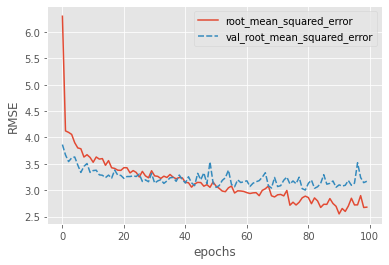

In [32]:
history_df = pd.DataFrame.from_dict(history.history)
sns.lineplot(data=history_df[['root_mean_squared_error', 'val_root_mean_squared_error']])
plt.xlabel("epochs")
plt.ylabel("RMSE")
#plt.savefig("03_training_history_4_rmse_dropout.png", dpi=200)

In [33]:
# Predict the sunshine hours
y_train_predicted = model.predict(X_train)
y_test_predicted = model.predict(X_test)

Text(0, 0.5, 'true sunshine hours')

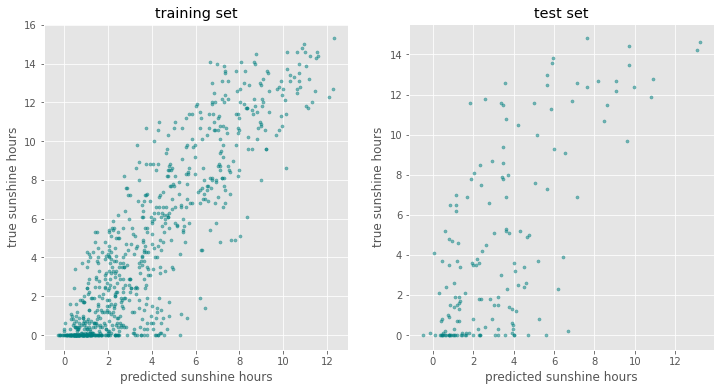

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.style.use('ggplot')
axes[0].scatter(y_train_predicted, y_train, s=10, alpha=0.5, color="teal")
axes[0].set_title("training set")
axes[0].set_xlabel("predicted sunshine hours")
axes[0].set_ylabel("true sunshine hours")

axes[1].scatter(y_test_predicted, y_test, s=10, alpha=0.5, color="teal")
axes[1].set_title("test set")
axes[1].set_xlabel("predicted sunshine hours")
axes[1].set_ylabel("true sunshine hours")

#plt.savefig("03_regression_compare_training_test_3_dropout.png", dpi=200)

# Compare to naive guess: tomorrow has same sunshine hours as today

Text(0, 0.5, 'true sunshine hours')

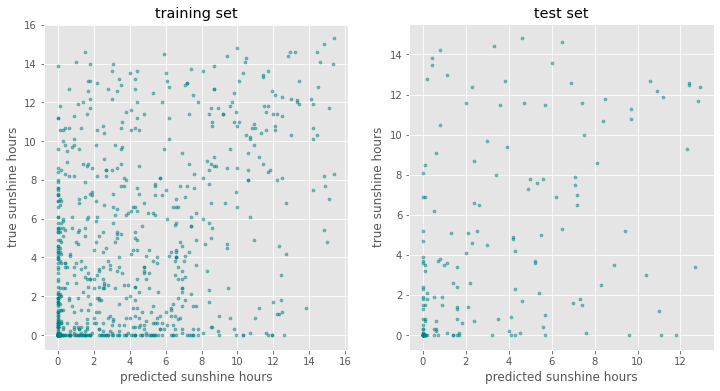

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.style.use('ggplot')
axes[0].scatter(X_train["DUSSELDORF_sunshine"], y_train, s=10, alpha=0.5, color="teal")
axes[0].set_title("training set")
axes[0].set_xlabel("predicted sunshine hours")
axes[0].set_ylabel("true sunshine hours")

axes[1].scatter(X_test["DUSSELDORF_sunshine"], y_test, s=10, alpha=0.5, color="teal")
axes[1].set_title("test set")
axes[1].set_xlabel("predicted sunshine hours")
axes[1].set_ylabel("true sunshine hours")

#plt.savefig("03_regression_compare_training_test_3_dropout.png", dpi=200)

# Improve network ->  Remedy 4: Use Dropout and BatchNormalization
- ....

In [49]:
def create_nn(n_features, n_predictions):
    # Input layer
    layers_input = keras.layers.Input(shape=(n_features,), name='input')

    # Dense layers
    layers_dense = keras.layers.BatchNormalization()(layers_input)
    layers_dense = keras.layers.Dense(100, 'relu')(layers_dense)
    layers_dense = keras.layers.Dropout(rate=0.2)(layers_dense)
    layers_dense = keras.layers.Dense(50, 'relu')(layers_dense)
    layers_dense = keras.layers.Dropout(rate=0.2)(layers_dense)
    layers_dense = keras.layers.Dense(10, 'relu')(layers_dense)

    # Output layer
    layers_output = keras.layers.Dense(n_predictions)(layers_dense)

    # Defining the model and compiling it
    return Model(inputs=layers_input, outputs=layers_output, name="dropout_prediction_model")

model = create_nn(X_data.shape[1], 1)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(1e-4),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "dropout_prediction_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 163)]             0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 163)               652       
_________________________________________________________________
dense_23 (Dense)             (None, 100)               16400     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 10)   

In [50]:
earlystopper = EarlyStopping(
    monitor='val_loss', mode="min",
    patience=20,
    verbose=1
    )

history = model.fit(X_train, y_train,
                    batch_size = 32,
                    epochs = 1000,
                    validation_data=(X_val, y_val),
                    callbacks=[earlystopper],
                    verbose = 2)

Epoch 1/1000
24/24 - 2s - loss: 43.5769 - root_mean_squared_error: 6.6013 - val_loss: 33.7263 - val_root_mean_squared_error: 5.8074
Epoch 2/1000
24/24 - 0s - loss: 41.5344 - root_mean_squared_error: 6.4447 - val_loss: 32.7318 - val_root_mean_squared_error: 5.7212
Epoch 3/1000
24/24 - 0s - loss: 39.7904 - root_mean_squared_error: 6.3080 - val_loss: 32.0040 - val_root_mean_squared_error: 5.6572
Epoch 4/1000
24/24 - 0s - loss: 38.3881 - root_mean_squared_error: 6.1958 - val_loss: 30.9868 - val_root_mean_squared_error: 5.5666
Epoch 5/1000
24/24 - 0s - loss: 36.9054 - root_mean_squared_error: 6.0750 - val_loss: 29.6289 - val_root_mean_squared_error: 5.4432
Epoch 6/1000
24/24 - 0s - loss: 34.6044 - root_mean_squared_error: 5.8826 - val_loss: 27.9178 - val_root_mean_squared_error: 5.2837
Epoch 7/1000
24/24 - 0s - loss: 32.9454 - root_mean_squared_error: 5.7398 - val_loss: 26.1477 - val_root_mean_squared_error: 5.1135
Epoch 8/1000
24/24 - 0s - loss: 30.2313 - root_mean_squared_error: 5.4983 - 

Epoch 63/1000
24/24 - 0s - loss: 10.0534 - root_mean_squared_error: 3.1707 - val_loss: 9.5191 - val_root_mean_squared_error: 3.0853
Epoch 64/1000
24/24 - 0s - loss: 10.0555 - root_mean_squared_error: 3.1710 - val_loss: 9.4832 - val_root_mean_squared_error: 3.0795
Epoch 65/1000
24/24 - 0s - loss: 10.3811 - root_mean_squared_error: 3.2220 - val_loss: 9.4667 - val_root_mean_squared_error: 3.0768
Epoch 66/1000
24/24 - 0s - loss: 9.9912 - root_mean_squared_error: 3.1609 - val_loss: 9.4773 - val_root_mean_squared_error: 3.0785
Epoch 67/1000
24/24 - 0s - loss: 10.2356 - root_mean_squared_error: 3.1993 - val_loss: 9.4757 - val_root_mean_squared_error: 3.0783
Epoch 68/1000
24/24 - 0s - loss: 9.9890 - root_mean_squared_error: 3.1605 - val_loss: 9.4225 - val_root_mean_squared_error: 3.0696
Epoch 69/1000
24/24 - 0s - loss: 10.2004 - root_mean_squared_error: 3.1938 - val_loss: 9.4083 - val_root_mean_squared_error: 3.0673
Epoch 70/1000
24/24 - 0s - loss: 9.4264 - root_mean_squared_error: 3.0702 - va

Epoch 126/1000
24/24 - 0s - loss: 8.6070 - root_mean_squared_error: 2.9338 - val_loss: 8.9358 - val_root_mean_squared_error: 2.9893
Epoch 127/1000
24/24 - 0s - loss: 8.4622 - root_mean_squared_error: 2.9090 - val_loss: 8.9552 - val_root_mean_squared_error: 2.9925
Epoch 128/1000
24/24 - 0s - loss: 8.6739 - root_mean_squared_error: 2.9452 - val_loss: 8.9500 - val_root_mean_squared_error: 2.9917
Epoch 129/1000
24/24 - 0s - loss: 8.3647 - root_mean_squared_error: 2.8922 - val_loss: 8.9060 - val_root_mean_squared_error: 2.9843
Epoch 130/1000
24/24 - 0s - loss: 8.3868 - root_mean_squared_error: 2.8960 - val_loss: 8.9283 - val_root_mean_squared_error: 2.9880
Epoch 131/1000
24/24 - 0s - loss: 8.3009 - root_mean_squared_error: 2.8811 - val_loss: 8.9295 - val_root_mean_squared_error: 2.9882
Epoch 132/1000
24/24 - 0s - loss: 8.7579 - root_mean_squared_error: 2.9594 - val_loss: 8.9426 - val_root_mean_squared_error: 2.9904
Epoch 133/1000
24/24 - 0s - loss: 8.3808 - root_mean_squared_error: 2.8950 -

Text(0, 0.5, 'RMSE')

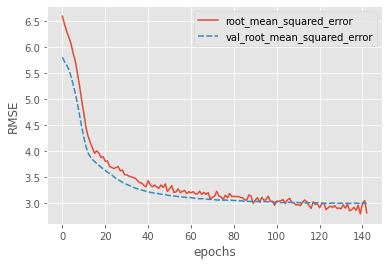

In [51]:
history_df = pd.DataFrame.from_dict(history.history)
sns.lineplot(data=history_df[['root_mean_squared_error', 'val_root_mean_squared_error']])
plt.xlabel("epochs")
plt.ylabel("RMSE")

In [52]:
# Predict the sunshine hours
y_train_predicted = model.predict(X_train)
y_test_predicted = model.predict(X_test)

Text(0, 0.5, 'true sunshine hours')

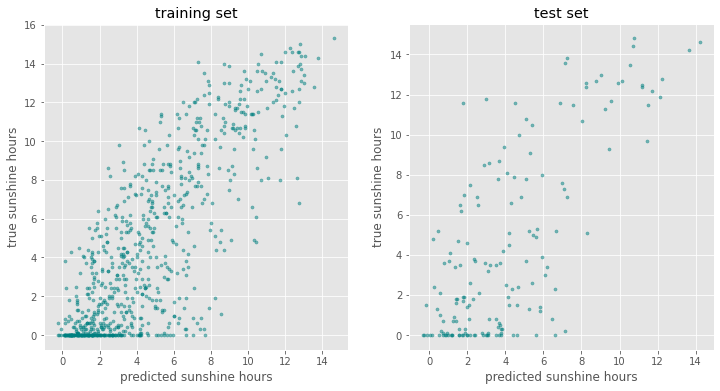

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.style.use('ggplot')
axes[0].scatter(y_train_predicted, y_train, s=10, alpha=0.5, color="teal")
axes[0].set_title("training set")
axes[0].set_xlabel("predicted sunshine hours")
axes[0].set_ylabel("true sunshine hours")

axes[1].scatter(y_test_predicted, y_test, s=10, alpha=0.5, color="teal")
axes[1].set_title("test set")
axes[1].set_xlabel("predicted sunshine hours")
axes[1].set_ylabel("true sunshine hours")

#plt.savefig("03_regression_compare_training_test_3_dropout.png", dpi=200)

## Conclusions:
- lowering learning rate makes training progress smoother
- overfitting is still very clearly visible

# 2) Optional teaching expansion: model uncertainty
## Using Monte-Carlo Dropout to evaluate model uncertainty

In [54]:
def create_nn(n_features, n_predictions):
    # Input layer
    layers_input = keras.layers.Input(shape=(n_features,), name='input')

    # Dense layers
    layers_dense = keras.layers.BatchNormalization()(layers_input)
    layers_dense = keras.layers.Dense(100, 'relu')(layers_dense)
    layers_dense = keras.layers.Dropout(rate=0.2)(layers_dense, training=True)
    layers_dense = keras.layers.Dense(50, 'relu')(layers_dense)
    layers_dense = keras.layers.Dropout(rate=0.2)(layers_dense, training=True)
    layers_dense = keras.layers.Dense(10, 'relu')(layers_dense)

    # Output layer
    layers_output = keras.layers.Dense(n_predictions)(layers_dense)

    # Defining the model and compiling it
    return Model(inputs=layers_input, outputs=layers_output, name="dropout_prediction_model")

model = create_nn(X_data.shape[1], 1)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(1e-4),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "dropout_prediction_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 163)]             0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 163)               652       
_________________________________________________________________
dense_27 (Dense)             (None, 100)               16400     
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_9 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 10)   

In [55]:
from tensorflow.keras.callbacks import EarlyStopping

earlystopper = EarlyStopping(
    monitor='val_loss', mode="min",
    patience=20,
    verbose=1
    )

history = model.fit(X_train, y_train,
                    batch_size = 32,
                    epochs = 1000,
                    validation_data=(X_val, y_val),
                    callbacks=[earlystopper],
                    verbose = 2)

Epoch 1/1000
24/24 - 2s - loss: 44.7381 - root_mean_squared_error: 6.6887 - val_loss: 43.1784 - val_root_mean_squared_error: 6.5710
Epoch 2/1000
24/24 - 0s - loss: 39.0034 - root_mean_squared_error: 6.2453 - val_loss: 31.8480 - val_root_mean_squared_error: 5.6434
Epoch 3/1000
24/24 - 0s - loss: 34.4554 - root_mean_squared_error: 5.8699 - val_loss: 25.0798 - val_root_mean_squared_error: 5.0080
Epoch 4/1000
24/24 - 0s - loss: 28.9674 - root_mean_squared_error: 5.3821 - val_loss: 22.4196 - val_root_mean_squared_error: 4.7349
Epoch 5/1000
24/24 - 0s - loss: 24.7635 - root_mean_squared_error: 4.9763 - val_loss: 19.0350 - val_root_mean_squared_error: 4.3629
Epoch 6/1000
24/24 - 0s - loss: 21.7934 - root_mean_squared_error: 4.6683 - val_loss: 17.2283 - val_root_mean_squared_error: 4.1507
Epoch 7/1000
24/24 - 0s - loss: 20.6502 - root_mean_squared_error: 4.5442 - val_loss: 17.0545 - val_root_mean_squared_error: 4.1297
Epoch 8/1000
24/24 - 0s - loss: 18.2409 - root_mean_squared_error: 4.2709 - 

Epoch 00062: early stopping


Text(0, 0.5, 'RMSE')

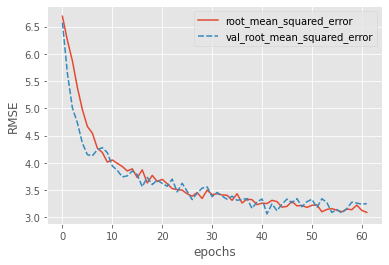

In [56]:
history_df = pd.DataFrame.from_dict(history.history)
sns.lineplot(data=history_df[['root_mean_squared_error', 'val_root_mean_squared_error']])
plt.xlabel("epochs")
plt.ylabel("RMSE")

Text(0, 0.5, 'true sunshine hours')

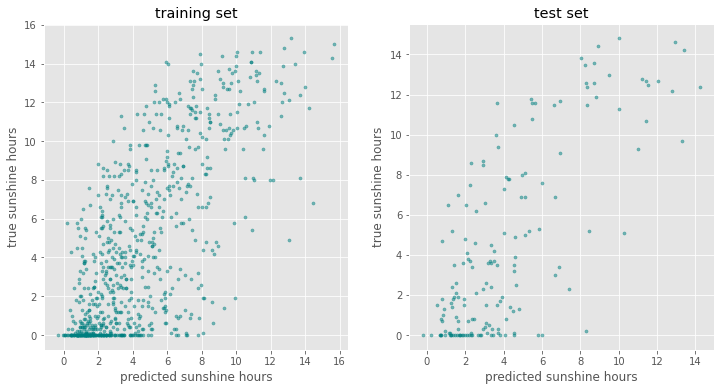

In [57]:
# Predict the sunshine hours
y_train_predicted = model.predict(X_train)
y_test_predicted = model.predict(X_test)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.style.use('ggplot')
axes[0].scatter(y_train_predicted, y_train, s=10, alpha=0.5, color="teal")
axes[0].set_title("training set")
axes[0].set_xlabel("predicted sunshine hours")
axes[0].set_ylabel("true sunshine hours")

axes[1].scatter(y_test_predicted, y_test, s=10, alpha=0.5, color="teal")
axes[1].set_title("test set")
axes[1].set_xlabel("predicted sunshine hours")
axes[1].set_ylabel("true sunshine hours")

#plt.savefig("03_regression_compare_training_test_3_dropout.png", dpi=200)

## Compute scores for multiple runs
- The model will look differntly each time due to Dropout randomly removing nodes. This can be seen as a ensemble of slightly different models.

In [58]:
from tqdm.notebook import tqdm

n_ensemble = 100
y_test_predicted_ensemble = np.zeros((X_test.shape[0], n_ensemble))

for i in tqdm(range(n_ensemble)):
    y_test_predicted_ensemble[:, i] = model.predict(X_test)[:,0]

  0%|          | 0/100 [00:00<?, ?it/s]

(array([ 3., 11., 11., 11., 15., 20., 12., 11.,  5.,  1.]),
 array([2.3126986 , 2.74628928, 3.17987995, 3.61347063, 4.0470613 ,
        4.48065197, 4.91424265, 5.34783332, 5.781424  , 6.21501467,
        6.64860535]),
 <BarContainer object of 10 artists>)

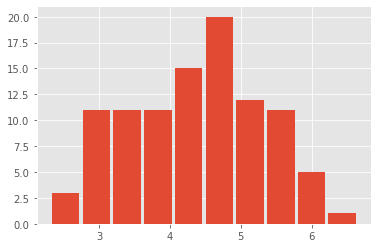

In [59]:
plt.hist(y_test_predicted_ensemble[0,:], rwidth=0.9)

### Take mean and standard deviation of the computed scores

In [60]:
y_test_predicted_mean = np.mean(y_test_predicted_ensemble, axis=1)
y_test_predicted_std = np.std(y_test_predicted_ensemble, axis=1)

In [61]:
y_test_predicted_std.min(), y_test_predicted_std.max()

(0.25857332908663155, 2.119025735182353)

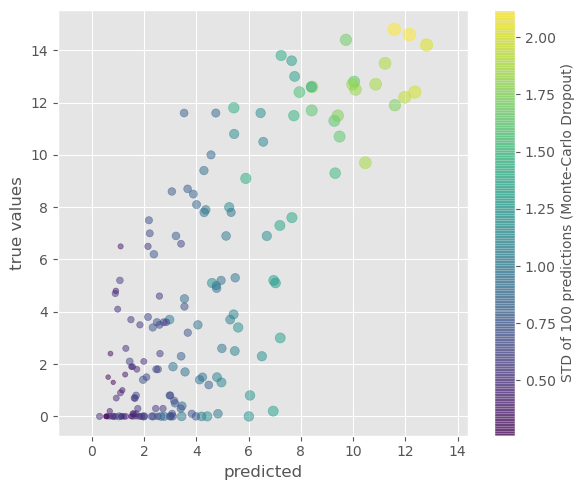

In [62]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=100)
plt.scatter(y_test_predicted_mean, y_test, s=40*y_test_predicted_std, 
            c=y_test_predicted_std, alpha=0.5)
plt.xlabel("predicted")
plt.ylabel("true values")
cbar = plt.colorbar()
cbar.set_label('STD of 100 predictions (Monte-Carlo Dropout)', rotation=90, fontsize=10)

ax.axis("equal")
fig.tight_layout()
#plt.savefig("sunshine_tomorrow_monte_carlo_dropout.png", dpi=300)
plt.savefig("sunshine_tomorrow_monte_carlo_dropout.pdf")

# Same easier to predict labels 1: global radiation

In [63]:
# labels
y_data = data.loc[1:(365*3 + 1)]["BASEL_global_radiation"]

predicted_labelname = "predicted global radiation"
true_labelname = "true global radiation"

# Split data into training, validation, and test set

In [64]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=0) 
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

print(f"Data split into training ({X_train.shape[0]})," \
      f" validation ({X_val.shape[0]}) and test set ({X_test.shape[0]}).") 

Data split into training (767), validation (164) and test set (165).


In [65]:
# this also shuffled the data!
y_train[:10]

459    0.72
182    2.52
428    0.34
816    2.09
10     0.06
454    1.45
821    2.22
579    2.14
753    0.29
849    1.62
Name: BASEL_global_radiation, dtype: float64

In [66]:
y_train.max(), y_train.min()

(3.52, 0.06)

# Build neural network

In [67]:
X_train.shape, y_train.shape

((767, 163), (767,))

In [68]:
from tensorflow import keras

def create_nn(n_features, n_predictions):
    # Input layer
    layers_input = keras.layers.Input(shape=(n_features,), name='input')

    # Dense layers
    layers_dense = keras.layers.BatchNormalization()(layers_input)
    layers_dense = keras.layers.Dense(100, 'relu')(layers_dense)
    layers_dense = keras.layers.Dropout(rate=0.2)(layers_dense, training=True)
    layers_dense = keras.layers.Dense(50, 'relu')(layers_dense)
    layers_dense = keras.layers.Dropout(rate=0.2)(layers_dense, training=True)
    layers_dense = keras.layers.Dense(10, 'relu')(layers_dense)

    # Output layer
    layers_output = keras.layers.Dense(n_predictions)(layers_dense)

    # Defining the model and compiling it
    return Model(inputs=layers_input, outputs=layers_output, name="dropout_prediction_model")

model = create_nn(X_data.shape[1], 1)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(1e-4),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "dropout_prediction_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 163)]             0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 163)               652       
_________________________________________________________________
dense_31 (Dense)             (None, 100)               16400     
_________________________________________________________________
dropout_10 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_11 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 10)   

In [69]:
from tensorflow.keras.callbacks import EarlyStopping

earlystopper = EarlyStopping(
    monitor='val_loss', mode="min",
    patience=20,
    verbose=1
    )

history = model.fit(X_train, y_train,
                    batch_size = 32,
                    epochs = 1000,
                    validation_data=(X_val, y_val),
                    callbacks=[earlystopper],
                    verbose = 2)

Epoch 1/1000
24/24 - 1s - loss: 2.5445 - root_mean_squared_error: 1.5951 - val_loss: 1.7813 - val_root_mean_squared_error: 1.3347
Epoch 2/1000
24/24 - 0s - loss: 1.7323 - root_mean_squared_error: 1.3162 - val_loss: 1.4009 - val_root_mean_squared_error: 1.1836
Epoch 3/1000
24/24 - 0s - loss: 1.2295 - root_mean_squared_error: 1.1088 - val_loss: 1.5368 - val_root_mean_squared_error: 1.2397
Epoch 4/1000
24/24 - 0s - loss: 1.0697 - root_mean_squared_error: 1.0343 - val_loss: 1.4211 - val_root_mean_squared_error: 1.1921
Epoch 5/1000
24/24 - 0s - loss: 0.9402 - root_mean_squared_error: 0.9697 - val_loss: 1.0756 - val_root_mean_squared_error: 1.0371
Epoch 6/1000
24/24 - 0s - loss: 0.9401 - root_mean_squared_error: 0.9696 - val_loss: 0.8872 - val_root_mean_squared_error: 0.9419
Epoch 7/1000
24/24 - 0s - loss: 0.7820 - root_mean_squared_error: 0.8843 - val_loss: 0.6634 - val_root_mean_squared_error: 0.8145
Epoch 8/1000
24/24 - 0s - loss: 0.7188 - root_mean_squared_error: 0.8478 - val_loss: 0.810

Epoch 64/1000
24/24 - 0s - loss: 0.3272 - root_mean_squared_error: 0.5720 - val_loss: 0.3283 - val_root_mean_squared_error: 0.5730
Epoch 65/1000
24/24 - 0s - loss: 0.3305 - root_mean_squared_error: 0.5749 - val_loss: 0.4076 - val_root_mean_squared_error: 0.6384
Epoch 66/1000
24/24 - 0s - loss: 0.3249 - root_mean_squared_error: 0.5700 - val_loss: 0.4017 - val_root_mean_squared_error: 0.6338
Epoch 67/1000
24/24 - 0s - loss: 0.3251 - root_mean_squared_error: 0.5702 - val_loss: 0.3424 - val_root_mean_squared_error: 0.5852
Epoch 68/1000
24/24 - 0s - loss: 0.3111 - root_mean_squared_error: 0.5578 - val_loss: 0.4242 - val_root_mean_squared_error: 0.6513
Epoch 69/1000
24/24 - 0s - loss: 0.3319 - root_mean_squared_error: 0.5761 - val_loss: 0.4275 - val_root_mean_squared_error: 0.6539
Epoch 70/1000
24/24 - 0s - loss: 0.3160 - root_mean_squared_error: 0.5621 - val_loss: 0.3346 - val_root_mean_squared_error: 0.5784
Epoch 71/1000
24/24 - 0s - loss: 0.3075 - root_mean_squared_error: 0.5545 - val_los

Text(0, 0.5, 'RMSE')

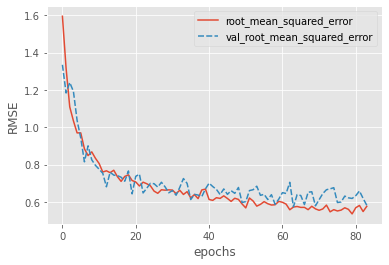

In [70]:
import seaborn as sns
#plt.style.use('ggplot')
history_df = pd.DataFrame.from_dict(history.history)
sns.lineplot(data=history_df[['root_mean_squared_error', 'val_root_mean_squared_error']])
plt.xlabel("epochs")
plt.ylabel("RMSE")

Text(0, 0.5, 'true global radiation')

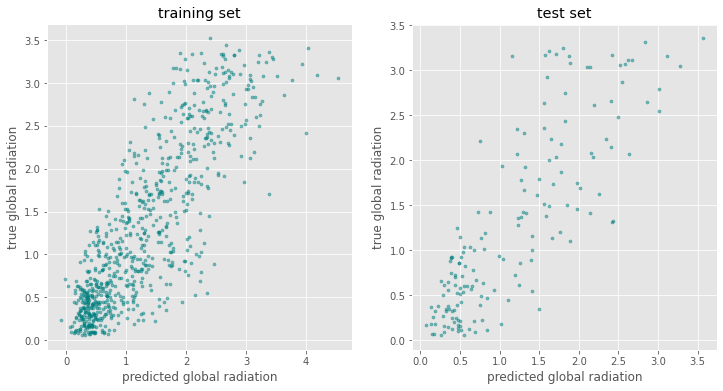

In [71]:
# Predict the sunshine hours
y_train_predicted = model.predict(X_train)
y_test_predicted = model.predict(X_test)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.style.use('ggplot')
axes[0].scatter(y_train_predicted, y_train, s=10, alpha=0.5, color="teal")
axes[0].set_title("training set")
axes[0].set_xlabel(predicted_labelname)
axes[0].set_ylabel(true_labelname)

axes[1].scatter(y_test_predicted, y_test, s=10, alpha=0.5, color="teal")
axes[1].set_title("test set")
axes[1].set_xlabel(predicted_labelname)
axes[1].set_ylabel(true_labelname)

#plt.savefig("03_regression_compare_training_test_3_dropout.png", dpi=200)

In [72]:
from tqdm.notebook import tqdm

n_ensemble = 100
y_test_predicted_ensemble = np.zeros((X_test.shape[0], n_ensemble))

for i in tqdm(range(n_ensemble)):
    y_test_predicted_ensemble[:, i] = model.predict(X_test)[:,0]

  0%|          | 0/100 [00:00<?, ?it/s]

(array([ 1.,  4., 12., 12., 19., 16., 21.,  8.,  5.,  2.]),
 array([0.39247507, 0.52133088, 0.65018668, 0.77904249, 0.90789829,
        1.0367541 , 1.16560991, 1.29446571, 1.42332152, 1.55217733,
        1.68103313]),
 <BarContainer object of 10 artists>)

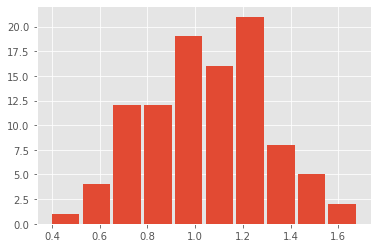

In [73]:
plt.hist(y_test_predicted_ensemble[0,:], rwidth=0.9)

In [74]:
y_test_predicted_mean = np.mean(y_test_predicted_ensemble, axis=1)
y_test_predicted_std = np.std(y_test_predicted_ensemble, axis=1)

In [75]:
y_test_predicted_std.min(), y_test_predicted_std.max()

(0.09103472406213588, 0.7025732711118742)

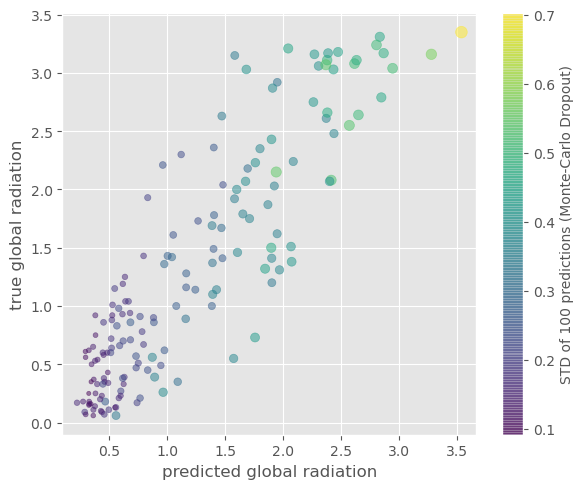

In [76]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=100)
plt.scatter(y_test_predicted_mean, y_test, s=100*y_test_predicted_std, 
            c=y_test_predicted_std, alpha=0.5)
plt.xlabel(predicted_labelname)
plt.ylabel(true_labelname)
cbar = plt.colorbar()
cbar.set_label('STD of 100 predictions (Monte-Carlo Dropout)', rotation=90, fontsize=10)

ax.axis("equal")
fig.tight_layout()
#plt.savefig("global_radiation_tomorrow_monte_carlo_dropout.png", dpi=300)
plt.savefig("global_radiation_tomorrow_monte_carlo_dropout.pdf")

# Same, but for easier to predict labels 2: max temperature

In [77]:
# labels
y_data = data.loc[1:(365*3 + 1)]["BASEL_temp_max"]

# Split data into training, validation, and test set

In [78]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=0) 
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

print(f"Data split into training ({X_train.shape[0]})," \
      f" validation ({X_val.shape[0]}) and test set ({X_test.shape[0]}).") 

Data split into training (767), validation (164) and test set (165).


In [79]:
# this also shuffled the data!
y_train[:10]

459    17.7
182    27.4
428     9.4
816    11.0
10      3.9
454    11.2
821    19.1
579    33.6
753     7.0
849    14.9
Name: BASEL_temp_max, dtype: float64

In [80]:
y_train.max(), y_train.min()

(34.2, -5.5)

# Build neural network

In [81]:
X_train.shape, y_train.shape

((767, 163), (767,))

In [82]:
from tensorflow import keras

def create_nn(n_features, n_predictions):
    # Input layer
    layers_input = keras.layers.Input(shape=(n_features,), name='input')

    # Dense layers
    layers_dense = keras.layers.BatchNormalization()(layers_input)
    layers_dense = keras.layers.Dense(100, 'relu')(layers_dense)
    layers_dense = keras.layers.Dropout(rate=0.2)(layers_dense, training=True)
    layers_dense = keras.layers.Dense(50, 'relu')(layers_dense)
    layers_dense = keras.layers.Dropout(rate=0.2)(layers_dense, training=True)
    layers_dense = keras.layers.Dense(10, 'relu')(layers_dense)

    # Output layer
    layers_output = keras.layers.Dense(n_predictions)(layers_dense)

    # Defining the model and compiling it
    return Model(inputs=layers_input, outputs=layers_output, name="dropout_prediction_model")

model = create_nn(X_data.shape[1], 1)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(1e-4),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "dropout_prediction_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 163)]             0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 163)               652       
_________________________________________________________________
dense_35 (Dense)             (None, 100)               16400     
_________________________________________________________________
dropout_12 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_13 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 10)   

In [83]:
from tensorflow.keras.callbacks import EarlyStopping

earlystopper = EarlyStopping(
    monitor='val_loss', mode="min",
    patience=20,
    verbose=1
    )

history = model.fit(X_train, y_train,
                    batch_size = 32,
                    epochs = 1000,
                    validation_data=(X_val, y_val),
                    callbacks=[earlystopper],
                    verbose = 2)

Epoch 1/1000
24/24 - 1s - loss: 343.2548 - root_mean_squared_error: 18.5271 - val_loss: 498.1819 - val_root_mean_squared_error: 22.3200
Epoch 2/1000
24/24 - 0s - loss: 311.0454 - root_mean_squared_error: 17.6365 - val_loss: 333.5851 - val_root_mean_squared_error: 18.2643
Epoch 3/1000
24/24 - 0s - loss: 278.0609 - root_mean_squared_error: 16.6752 - val_loss: 276.1407 - val_root_mean_squared_error: 16.6175
Epoch 4/1000
24/24 - 0s - loss: 247.4629 - root_mean_squared_error: 15.7310 - val_loss: 223.8133 - val_root_mean_squared_error: 14.9604
Epoch 5/1000
24/24 - 0s - loss: 210.5236 - root_mean_squared_error: 14.5094 - val_loss: 182.1791 - val_root_mean_squared_error: 13.4974
Epoch 6/1000
24/24 - 0s - loss: 173.5723 - root_mean_squared_error: 13.1747 - val_loss: 138.7582 - val_root_mean_squared_error: 11.7796
Epoch 7/1000
24/24 - 0s - loss: 141.2190 - root_mean_squared_error: 11.8836 - val_loss: 111.3535 - val_root_mean_squared_error: 10.5524
Epoch 8/1000
24/24 - 0s - loss: 109.1802 - root_

Epoch 63/1000
24/24 - 0s - loss: 17.6083 - root_mean_squared_error: 4.1962 - val_loss: 21.0740 - val_root_mean_squared_error: 4.5906
Epoch 64/1000
24/24 - 0s - loss: 18.5168 - root_mean_squared_error: 4.3031 - val_loss: 18.4560 - val_root_mean_squared_error: 4.2960
Epoch 65/1000
24/24 - 0s - loss: 17.9394 - root_mean_squared_error: 4.2355 - val_loss: 16.7337 - val_root_mean_squared_error: 4.0907
Epoch 66/1000
24/24 - 0s - loss: 16.5315 - root_mean_squared_error: 4.0659 - val_loss: 19.0083 - val_root_mean_squared_error: 4.3598
Epoch 67/1000
24/24 - 0s - loss: 16.3502 - root_mean_squared_error: 4.0435 - val_loss: 18.3333 - val_root_mean_squared_error: 4.2817
Epoch 68/1000
24/24 - 0s - loss: 17.6500 - root_mean_squared_error: 4.2012 - val_loss: 19.0614 - val_root_mean_squared_error: 4.3659
Epoch 69/1000
24/24 - 0s - loss: 16.2621 - root_mean_squared_error: 4.0326 - val_loss: 18.7189 - val_root_mean_squared_error: 4.3265
Epoch 70/1000
24/24 - 0s - loss: 16.7920 - root_mean_squared_error: 4

Epoch 125/1000
24/24 - 0s - loss: 12.8095 - root_mean_squared_error: 3.5790 - val_loss: 13.0730 - val_root_mean_squared_error: 3.6157
Epoch 126/1000
24/24 - 0s - loss: 13.9490 - root_mean_squared_error: 3.7348 - val_loss: 14.3774 - val_root_mean_squared_error: 3.7917
Epoch 127/1000
24/24 - 0s - loss: 13.5455 - root_mean_squared_error: 3.6804 - val_loss: 13.9944 - val_root_mean_squared_error: 3.7409
Epoch 128/1000
24/24 - 0s - loss: 11.5396 - root_mean_squared_error: 3.3970 - val_loss: 14.1020 - val_root_mean_squared_error: 3.7553
Epoch 129/1000
24/24 - 0s - loss: 14.7707 - root_mean_squared_error: 3.8433 - val_loss: 14.4045 - val_root_mean_squared_error: 3.7953
Epoch 130/1000
24/24 - 0s - loss: 12.7415 - root_mean_squared_error: 3.5695 - val_loss: 13.6573 - val_root_mean_squared_error: 3.6956
Epoch 131/1000
24/24 - 0s - loss: 12.9400 - root_mean_squared_error: 3.5972 - val_loss: 14.1972 - val_root_mean_squared_error: 3.7679
Epoch 132/1000
24/24 - 0s - loss: 12.5332 - root_mean_squared_

Text(0, 0.5, 'RMSE')

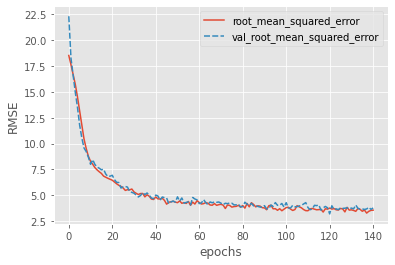

In [84]:
import seaborn as sns
#plt.style.use('ggplot')
history_df = pd.DataFrame.from_dict(history.history)
sns.lineplot(data=history_df[['root_mean_squared_error', 'val_root_mean_squared_error']])
plt.xlabel("epochs")
plt.ylabel("RMSE")

Text(0, 0.5, 'true max. temperature')

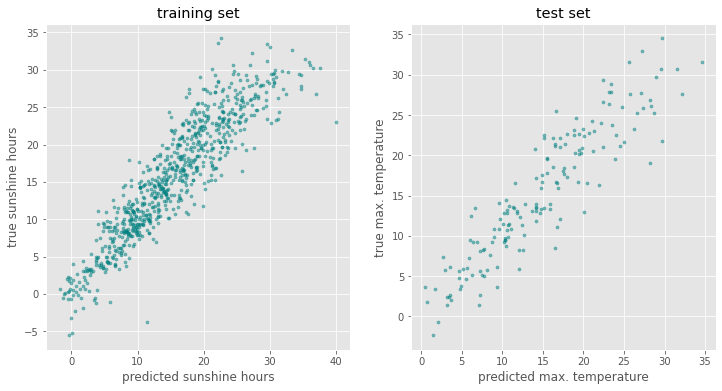

In [85]:
# Predict the sunshine hours
y_train_predicted = model.predict(X_train)
y_test_predicted = model.predict(X_test)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.style.use('ggplot')
axes[0].scatter(y_train_predicted, y_train, s=10, alpha=0.5, color="teal")
axes[0].set_title("training set")
axes[0].set_xlabel("predicted sunshine hours")
axes[0].set_ylabel("true sunshine hours")

axes[1].scatter(y_test_predicted, y_test, s=10, alpha=0.5, color="teal")
axes[1].set_title("test set")
axes[1].set_xlabel("predicted max. temperature")
axes[1].set_ylabel("true max. temperature")

#plt.savefig("03_regression_compare_training_test_3_dropout.png", dpi=200)

### Compute scores for multiple runs

In [86]:
from tqdm.notebook import tqdm

n_ensemble = 100
y_test_predicted_ensemble = np.zeros((X_test.shape[0], n_ensemble))

for i in tqdm(range(n_ensemble)):
    y_test_predicted_ensemble[:, i] = model.predict(X_test)[:,0]

  0%|          | 0/100 [00:00<?, ?it/s]

(array([ 1.,  7.,  8., 10., 21., 24., 13.,  9.,  5.,  2.]),
 array([10.59019184, 11.61721601, 12.64424019, 13.67126436, 14.69828854,
        15.72531271, 16.75233688, 17.77936106, 18.80638523, 19.8334094 ,
        20.86043358]),
 <BarContainer object of 10 artists>)

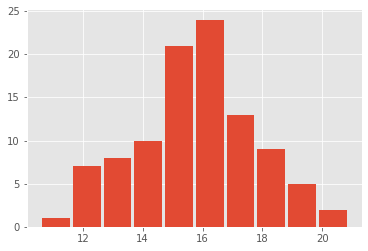

In [87]:
plt.hist(y_test_predicted_ensemble[0,:], rwidth=0.9)

In [88]:
y_test_predicted_mean = np.mean(y_test_predicted_ensemble, axis=1)
y_test_predicted_std = np.std(y_test_predicted_ensemble, axis=1)

In [89]:
y_test_predicted_std.min(), y_test_predicted_std.max()

(0.7763688110013475, 4.076797457788782)

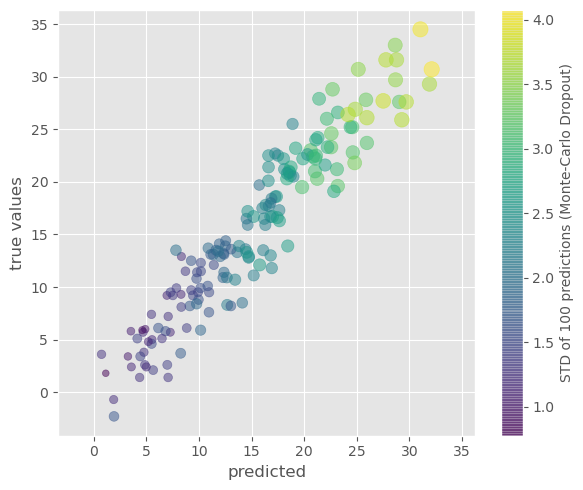

In [90]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=100)
plt.scatter(y_test_predicted_mean, y_test, s=30*y_test_predicted_std, 
            c=y_test_predicted_std, alpha=0.5)
plt.xlabel("predicted")
plt.ylabel("true values")
cbar = plt.colorbar()
cbar.set_label('STD of 100 predictions (Monte-Carlo Dropout)', rotation=90, fontsize=10)

ax.axis("equal")
fig.tight_layout()
#plt.savefig("max_temp_tomorrow_monte_carlo_dropout.png", dpi=300)
plt.savefig("max_temp_tomorrow_monte_carlo_dropout.pdf")